# Initialisation

In [1]:
import os #To get the Current working directory
import numpy as np #To create the neural network and work with mathematics
import torchvision #To load the dataset and get a numpy array
import matplotlib.pyplot as plt #Ability to display plots and pictures
import seaborn as sns           #Ability to display plots and pictures

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def IndexVectorToMatrix(IndexVector, nCols):
    Result = np.zeros((len(IndexVector), nCols))
    for i in range(len(IndexVector)):
        Result[i, int(IndexVector[i])] = 1
    return Result
    
def PlotMetrics(trainLoss, TrainAccuracies, testLoss = None, testAccuracy = None, Alpha = 0.9, figsize = [18, 7]):
    OriginalFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = figsize
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("Loss")
    ax1.plot(trainLoss, label = f"Train Loss")
    if testLoss is not None:
        ax1.plot(testLoss, label = f"Validation Loss", alpha = Alpha)
    ax1.legend()
    ax2.set_title("Accuracy")
    ax2.plot(TrainAccuracies, label = f"Train Accuracy")
    if testAccuracy is not None:
        ax2.plot(testAccuracy, label = f"Validation Accuracy", alpha = Alpha)
    ax2.legend()
    plt.show()
    plt.rcParams['figure.figsize'] = OriginalFigSize

def DisplayConfusionMatrix(testY, output, ClassNames, figsize = [18, 9]):
    OriginalFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = figsize
    ConfusionMatrixDisplay(confusion_matrix(testY, output), display_labels = ClassNames).plot()
    plt.show()
    plt.rcParams['figure.figsize'] = OriginalFigSize

# Data

In [39]:
path_root = f"{os.getcwd()}"
path_data = f"{path_root}/Data"
print(path_root)
print(path_data, "\n")

c:\Users\dsxma\Downloads
c:\Users\dsxma\Downloads/Data 



In [45]:
Seed = 2       #Reproducibility

#Using PyTorch's datasets to get access to the FashionMNIST data
train_dataset = torchvision.datasets.FashionMNIST(
    root = f'{path_data}',
    train = True,
    transform = None,
    download = True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = f'{path_data}',
    train = False,
    transform = None,
    download = True
)

ClassNames = train_dataset.classes            #Getting the Classes
trainX = train_dataset.data.cpu().numpy()    #Getting Training input tensor
trainY = train_dataset.targets.cpu().numpy() #Getting Training target vector
testX = test_dataset.data.cpu().numpy()      #Getting Testing input tensor
testY = test_dataset.targets.cpu().numpy()   #Getting Testing target vector

N, H1, W1 = trainX.shape
C1 = 1 #Monochromatic so 1 colour channel
K = len(set(trainY)) #Number of classes
D = H1 * W1 #The dimensionality of the dataset
print(f"N: {N}, H1: {H1}, W1: {W1}, C1: {C1}, K: {K}")
print("Class Names:", ClassNames)
print(f"\nBefore scaling: Min ({trainX.min()}),   Max ({trainX.max()}), Data type ({trainX.dtype})")

#Data Scaling.
#Original data goes from 0 to 255
trainX = (trainX / 255).astype(np.float32)
testX = (testX / 255).astype(np.float32)

N: 60000, H1: 28, W1: 28, C1: 1, K: 10
Class Names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Before scaling: Min (0),   Max (255), Data type (uint8)


# Functions

In [50]:
def Softmax(x): #Softmax implementation from scratch. Making along axis 1 a probability distribution (should sum up to 1) hence axis = 1, keepdims = True
    calculateExponent = np.exp(x)
    return calculateExponent / np.sum(calculateExponent, axis = 1, keepdims = True)

def Relu(x): #ReLU implementation from scratch
    return x * (x > 0)

def Sigmoid(x): #Implementing Sigmoid from mathematics
    if np.all(x >= 0): #It overflows if x is negative
        return 1 / (1 + np.exp(-x))
    else:
        calculateExponent = np.exp(x)
        return calculateExponent / (1 + calculateExponent)

def Cost(target, preds): #Categorical Cross Entropy implementation from scratch
    return -np.mean(target * np.log(preds))

# Neural Network

## Architecture

In [173]:
class nueralNetwork():
    
    
    def __init__(self, W, b, activationFunction, deltaOfW, deltaOfB, derivativeOfW, derivativeOfB):
        
        self.W          = W
        self.activationFunction = activationFunction
        self.derivativeOfB     = derivativeOfB
        self.deltaOfB     = deltaOfB
        self.derivativeOfW     = derivativeOfW
        self.Training   = False
        self.Z0         = None
        self.b          = b
        self.deltaOfW     = deltaOfW

    def takeStep(self, Eta):
        self.W -= (Eta * self.derivativeOfW)
        self.b -= (Eta * self.derivativeOfB)

    #changes to evaluation mode
    def Evaluation(self):
        self.Training = False

    #Implements ReLu
    def reluDerivative(self, Z):
        return np.sign(Z)
        
    
        
    def deltaOutputW(self, Target, Pred, K):
        return Pred - IndexVectorToMatrix(Target, K) #The output of the model is NxK but the Target is N, so Target gets converted into an NxK matrix
    def deltaOutputB(self):
        return np.sum(self.deltaOfW.copy(), axis = 0)

    def derivativeB(self):
        return self.deltaOfB.copy()
        
    def deltaW(self, Delta, W, Z, activationFunction):
        return Delta.dot(W.T) * (self.sigmoidDerivative(Z) if activationFunction.lower() == "sigmoid" else self.reluDerivative(Z))
        
    def deltaB(self):
        #calculates Delta b
        return np.sum(self.deltaOfW.copy(), axis = 0)
        
    
        
    def forwardPropagation(self, X):
        #Forward pass of the Nueral network
        if self.Training:
            self.Z0 = X.copy()
        Res = X.dot(self.W) + self.b
        Res = Sigmoid(Res) if self.activationFunction.lower() == "sigmoid" else Relu(Res) if self.activationFunction.lower() == "relu" else Softmax(Res)
        return Res

    def sigmoidDerivative(self, Z):
        #Sigmmoids derivative
        return Z * (1 - Z)
    
    def Train(self):
        #Switches to training mode
        self.Training = True

    def derivativeW(self):
        return self.Z0.T.dot(self.deltaOfW)
        
    
    
    

In [177]:
class forwardPropNetwork():
    """Implements a Multi-Layer Feed-forwardPropagation Neural Network"""
    
    def __init__(self, D, numberOfUnits, activationFunction):
        self.Training = False
        self.D = D
        self.numberOfUnits = numberOfUnits
        self.activationFunction = activationFunction
        self.numberOfLayers = len(numberOfUnits) #The number of layers is the length of the list containing the number of units per layer
        self.layers = []
        
        previous = self.D #The dimensionality of the weights is always the dimensionality of the Previous layer times that of the Following layer
        for Layer in range(self.numberOfLayers):
            next = self.numberOfUnits[Layer] #The dimensionality of each following layer is given by the numberOfUnits hyperparameter
            self.layers.append(
                nueralNetwork(
                    W = np.random.normal(size = (previous, next)) / np.sqrt(previous), #Initialising the weights
                    b = np.random.normal(size = next),                             #Initialising the weights
                    activationFunction = self.activationFunction[Layer],                            #The σ activationFunction function to be used
                    deltaOfW = None,                                                   #Instantiating the derivatives
                    deltaOfB = None,                                                   #Instantiating the derivatives
                    derivativeOfW = None,                                                   #Instantiating the derivatives
                    derivativeOfB = None                                                    #Instantiating the derivatives
                )
            )
            previous = next #At the end of the construction of the current layer, we update what's considered the dimensionality of the previous layer to our previous "future layer"
    
    def forwardPropagation(self, X):
        """Perform the forward direction over the whole network to produce the end results"""
        Result = X.reshape(len(X), -1) #Uses and updates the input X for subsequent layers
        for i in range(self.numberOfLayers): #Iterating over all layers
            Result = self.layers[i].forwardPropagation(Result)  #Applies each layer
        return Result
    
    def Backward(self, Y, Pred, Eta):
        """Calculate the Gradient of the Loss function with respect to the parameters"""
        self.layers[-1].deltaOfW = self.layers[-1].deltaOutputW(Y, Pred, self.numberOfUnits[-1]) #The last Z (Z_L) is Y, the predictions.
        self.layers[-1].deltaOfB = self.layers[-1].deltaOutputB()
        self.layers[-1].derivativeOfW = self.layers[-1].derivativeW()    
        self.layers[-1].derivativeOfB = self.layers[-1].derivativeB()
        self.layers[-1].takeStep(Eta)
        
        if self.numberOfLayers > 1:
            #Calculating the Gradients of the rest of the layers
            for Layer in range(self.numberOfLayers-2, -1, -1): 
                self.layers[Layer].deltaOfW = self.layers[Layer].deltaW(self.layers[Layer + 1].deltaOfW, self.layers[Layer + 1].W, self.layers[Layer + 1].Z0, self.layers[Layer].activationFunction)
                self.layers[Layer].deltaOfB = self.layers[Layer].deltaB()
                self.layers[Layer].derivativeOfW = self.layers[Layer].derivativeW()
                self.layers[Layer].derivativeOfB = self.layers[Layer].derivativeB()
                self.layers[Layer].takeStep(Eta)
    
    def Train(self):
        """Switches the network to Training mode and Z0 is saved for backprop calculations"""
        for Layer in range(self.numberOfLayers):
            self.layers[Layer].Train()
    
    def Evaluation(self):
        """Switches the network to Evaluation mode and Z0 is not saved"""
        for Layer in range(self.numberOfLayers):
            self.layers[Layer].Evaluation()
    
    def __len__(self):
        """Defining the Network's length"""
        return self.numberOfLayers

## Hyperparameters 1

### Neural Network Model

In [183]:
#Initialising variables
sumTrainingLosses     = [] 
Runs = 100
sumTrainingAccuracy = [] 
numberOfUnits = [100, 50, K]
sumTestAccuracy  = [] 
printRuns = 10
learningRate = 5e-6
sumTestLosses    = [] 

activationFunctions = ["Relu", "Sigmoid"] + ["Softmax"] #Relu, Sigmoid

#Starting the model
model = forwardPropNetwork(D, numberOfUnits, activationFunctions)






### Optimisation

In [184]:
#Gradient Descent: Learning using Backpropagation of error.
for run in range(Runs):
    model.Train()
    outputProbability = model.forwardPropagation(trainX)
    output = np.argmax(outputProbability, axis = 1)
    probabilityTrainOfY = IndexVectorToMatrix(trainY, K)
    trainLoss = Cost(probabilityTrainOfY, outputProbability)
    trainAccuracy = np.mean(output == trainY)
    
    #Descending the gradient
    model.Backward(trainY, outputProbability, learningRate)
    
    ### Evaluation ###
    model.Evaluation()
    outputProbability = model.forwardPropagation(testX)
    output = np.argmax(outputProbability, axis = 1)
    probabilityTestY = IndexVectorToMatrix(testY, K)
    testLoss = Cost(probabilityTestY, outputProbability)
    testAccuracy = np.mean(output == testY)
    
    #Saving the metrics for the current iteration
    sumTrainingLosses.append(trainLoss)
    sumTrainingAccuracy.append(trainAccuracy)
    sumTestLosses.append(testLoss)
    sumTestAccuracy.append(testAccuracy)    
    
    #Printing information about the Loss and metrics
    if (run + 1) % printRuns == 0 or run == 0 or run == Runs - 1:
        print(f'Run {run + 1}/{Runs}, Train Loss: {trainLoss:.4f}, Test Loss: {testLoss:.4f} | Train Acc: {trainAccuracy:.2f}, Test Acc: {testAccuracy:.2f}')

Run 1/100, Train Loss: 0.3199, Test Loss: 0.2609 | Train Acc: 0.10, Test Acc: 0.08
Run 10/100, Train Loss: 0.2180, Test Loss: 0.2160 | Train Acc: 0.42, Test Acc: 0.43
Run 20/100, Train Loss: 0.1902, Test Loss: 0.1867 | Train Acc: 0.55, Test Acc: 0.56
Run 30/100, Train Loss: 0.1558, Test Loss: 0.1533 | Train Acc: 0.58, Test Acc: 0.59
Run 40/100, Train Loss: 0.1324, Test Loss: 0.1310 | Train Acc: 0.63, Test Acc: 0.63
Run 50/100, Train Loss: 0.1168, Test Loss: 0.1161 | Train Acc: 0.67, Test Acc: 0.66
Run 60/100, Train Loss: 0.1056, Test Loss: 0.1054 | Train Acc: 0.69, Test Acc: 0.69
Run 70/100, Train Loss: 0.0972, Test Loss: 0.0974 | Train Acc: 0.70, Test Acc: 0.70
Run 80/100, Train Loss: 0.0906, Test Loss: 0.0910 | Train Acc: 0.71, Test Acc: 0.71
Run 90/100, Train Loss: 0.0852, Test Loss: 0.0859 | Train Acc: 0.73, Test Acc: 0.72
Run 100/100, Train Loss: 0.0809, Test Loss: 0.0817 | Train Acc: 0.73, Test Acc: 0.73


### Evaluation

## Hyperparameters 2

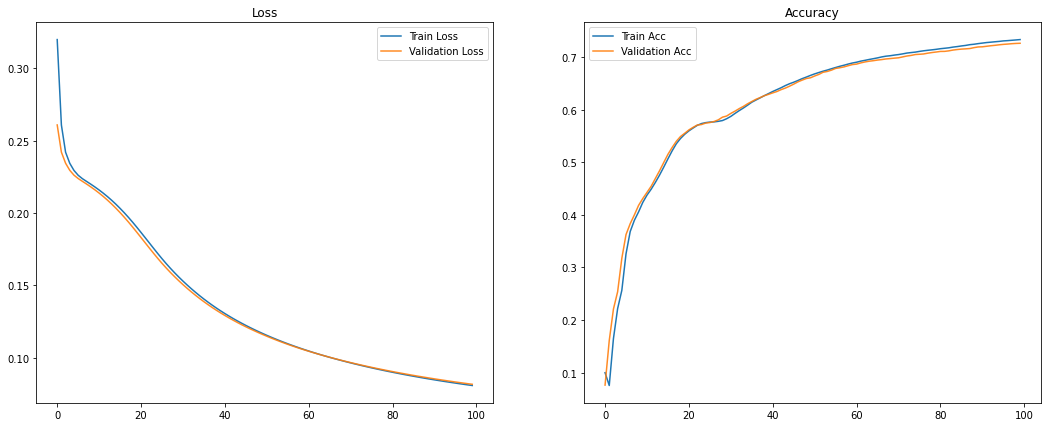

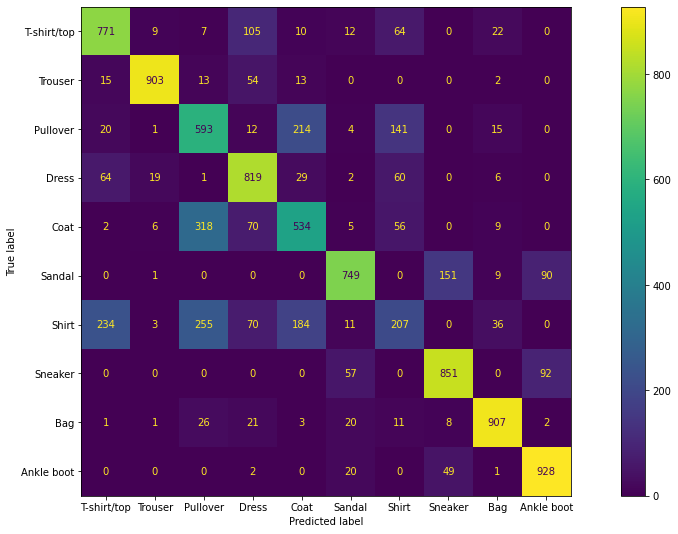

In [186]:
#Plotting the metrics for Train and Test sets
PlotMetrics(sumTrainingLosses, sumTrainingAccuracy, sumTestLosses, sumTestAccuracy, Alpha = 0.9)

#Plotting the confusion matrix
DisplayConfusionMatrix(testY, output, ClassNames, figsize = [18, 9])

### Neural Network Model

In [189]:
#Configuring the Network
Runs = 100
printRuns = 100
learningRate = 5e-11
numberOfUnits = [1000, 500, K]
activationFunctions = ["Relu", "Sigmoid"] + ["Softmax"] #Relu, Sigmoid

#Instantiating new model here
model = forwardPropNetwork(D, numberOfUnits, activationFunctions)

sumTrainingLosses     = [] 
sumTrainingAccuracy = [] 
sumTestAccuracy  = [] 
sumTestLosses    = [] 

### Optimisation

In [190]:
#Gradient Descent: Learning using Backpropagation of error.
for run in range(Runs):
    model.Train()
    outputProbability = model.forwardPropagation(trainX)
    output = np.argmax(outputProbability, axis = 1)
    probabilityTrainOfY = IndexVectorToMatrix(trainY, K)
    trainLoss = Cost(probabilityTrainOfY, outputProbability)
    trainAccuracy = np.mean(output == trainY)
    
    #Descending the gradient
    model.Backward(trainY, outputProbability, learningRate)
    
    #Evaluation
    model.Evaluation()
    outputProbability = model.forwardPropagation(testX)
    output = np.argmax(outputProbability, axis = 1)
    probabilityTestY = IndexVectorToMatrix(testY, K)
    testLoss = Cost(probabilityTestY, outputProbability)
    testAccuracy = np.mean(output == testY)
    
    #Saving the metrics
    sumTrainingLosses.append(trainLoss)
    sumTrainingAccuracy.append(trainAccuracy)
    sumTestLosses.append(testLoss)
    sumTestAccuracy.append(testAccuracy)    
    
    #Printing information about the Loss and metrics
    if (run + 1) % printRuns == 0 or run == 0 or run == Runs - 1:
        print(f'Run {run + 1}/{Runs}, Train Loss: {trainLoss:.4f}, Test Loss: {testLoss:.4f} | Train Acc: {trainAccuracy:.2f}, Test Acc: {testAccuracy:.2f}')

Run 1/100, Train Loss: 0.2500, Test Loss: 0.2500 | Train Acc: 0.10, Test Acc: 0.10
Run 100/100, Train Loss: 0.2496, Test Loss: 0.2496 | Train Acc: 0.10, Test Acc: 0.10


### Evaluation

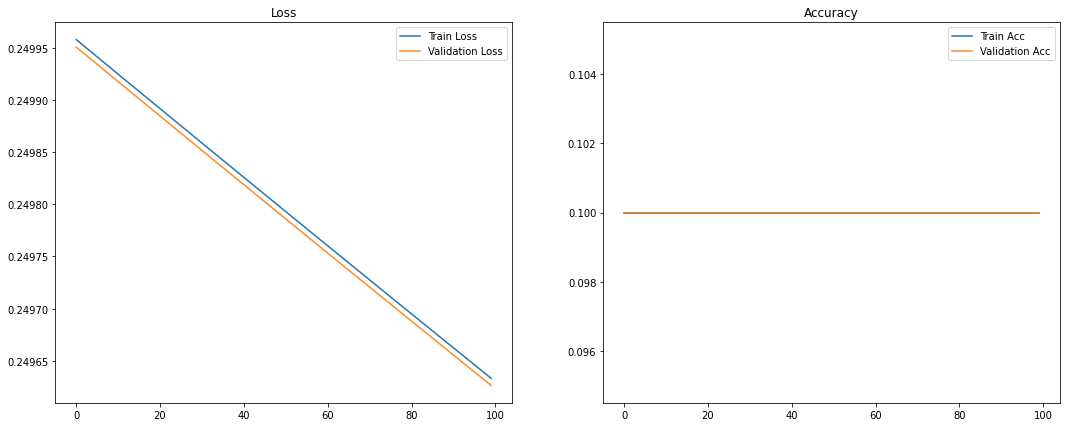

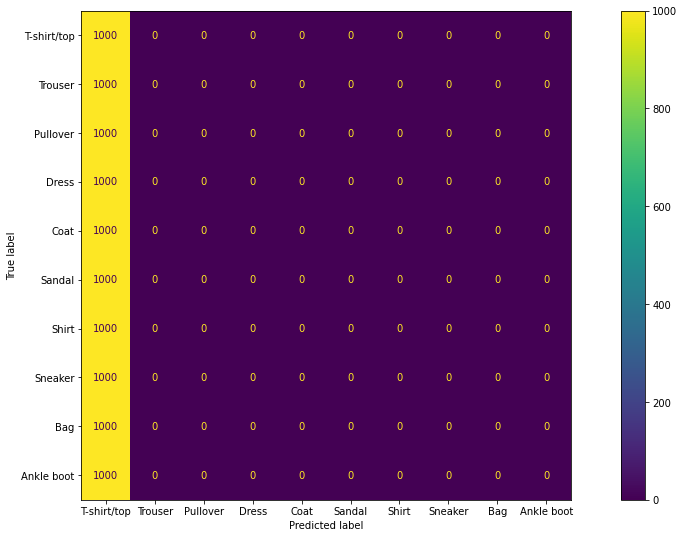

In [193]:
#Plotting the metrics for Train and Test sets
PlotMetrics(sumTrainingLosses, sumTrainingAccuracy, sumTestLosses, sumTestAccuracy, Alpha = 0.9)

#Plotting the confusion matrix
DisplayConfusionMatrix(testY, output, ClassNames, figsize = [18, 9])

## Hyperparameters 3

### Neural Network Model

In [195]:
#Configuring the Network
Runs = 90
printRuns = 5
learningRate = 5e-6
numberOfUnits = [50, 100, K]
activationFunctions = ["Relu", "Sigmoid"] + ["Softmax"] #Relu, Sigmoid

#Instantiating new model here, so if we can continue training by re-running the Optimisation code and the model only resets when this cell runs again to create a new instance
model = forwardPropNetwork(D, numberOfUnits, activationFunctions)

sumTrainingLosses     = [] 
sumTrainingAccuracy = [] 
sumTestAccuracy  = [] 
sumTestLosses    = []


### Optimisation

In [196]:
#Gradient Descent: Learning using Backpropagation of error.
for run in range(Runs):
    model.Train()
    outputProbability = model.forwardPropagation(trainX)
    output = np.argmax(outputProbability, axis = 1)
    probabilityTrainOfY = IndexVectorToMatrix(trainY, K)
    trainLoss = Cost(probabilityTrainOfY, outputProbability)
    trainAccuracy = np.mean(output == trainY)
    
    #Descending the gradient
    model.Backward(trainY, outputProbability, learningRate)
    
    model.Evaluation()
    outputProbability = model.forwardPropagation(testX)
    output = np.argmax(outputProbability, axis = 1)
    probabilityTestY = IndexVectorToMatrix(testY, K)
    testLoss = Cost(probabilityTestY, outputProbability)
    testAccuracy = np.mean(output == testY)
    
    #Saving the statistics of the runs
    sumTrainingLosses.append(trainLoss)
    sumTrainingAccuracy.append(trainAccuracy)
    sumTestLosses.append(testLoss)
    sumTestAccuracy.append(testAccuracy)    
    
    #Printing the statistics
    if (run + 1) % printRuns == 0 or run == 0 or run == Runs - 1:
        print(f'Run {run + 1}/{Runs}, Train Loss: {trainLoss:.4f}, Test Loss: {testLoss:.4f} | Train Acc: {trainAccuracy:.2f}, Test Acc: {testAccuracy:.2f}')

Run 1/90, Train Loss: 0.2724, Test Loss: 0.2384 | Train Acc: 0.10, Test Acc: 0.13
Run 5/90, Train Loss: 0.2243, Test Loss: 0.2224 | Train Acc: 0.40, Test Acc: 0.48
Run 10/90, Train Loss: 0.2123, Test Loss: 0.2093 | Train Acc: 0.56, Test Acc: 0.57
Run 15/90, Train Loss: 0.1938, Test Loss: 0.1895 | Train Acc: 0.59, Test Acc: 0.59
Run 20/90, Train Loss: 0.1715, Test Loss: 0.1675 | Train Acc: 0.60, Test Acc: 0.60
Run 25/90, Train Loss: 0.1522, Test Loss: 0.1493 | Train Acc: 0.61, Test Acc: 0.61
Run 30/90, Train Loss: 0.1375, Test Loss: 0.1356 | Train Acc: 0.63, Test Acc: 0.63
Run 35/90, Train Loss: 0.1263, Test Loss: 0.1250 | Train Acc: 0.65, Test Acc: 0.64
Run 40/90, Train Loss: 0.1174, Test Loss: 0.1166 | Train Acc: 0.66, Test Acc: 0.66
Run 45/90, Train Loss: 0.1102, Test Loss: 0.1098 | Train Acc: 0.68, Test Acc: 0.68
Run 50/90, Train Loss: 0.1041, Test Loss: 0.1040 | Train Acc: 0.69, Test Acc: 0.69
Run 55/90, Train Loss: 0.0990, Test Loss: 0.0991 | Train Acc: 0.70, Test Acc: 0.70
Run 60

### Evaluation

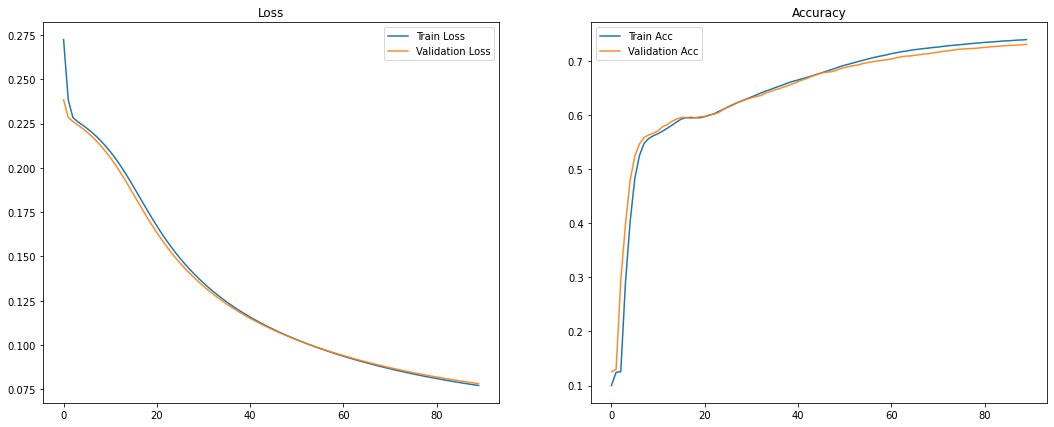

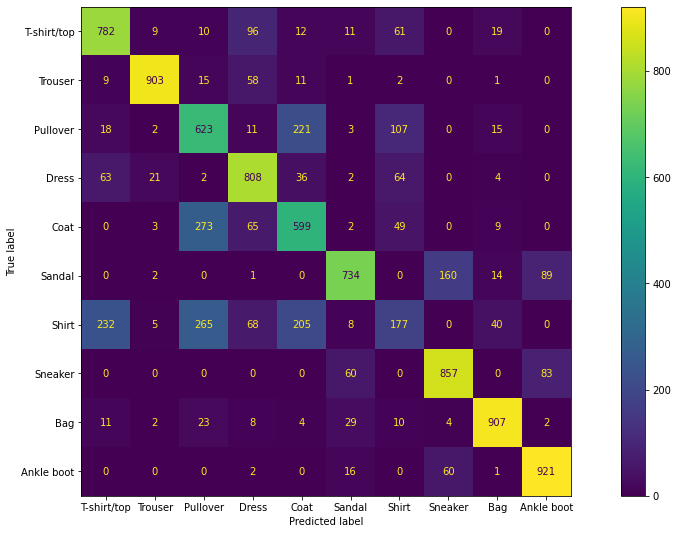

In [198]:
#Plotting the metrics for Train and Test sets
PlotMetrics(sumTrainingLosses, sumTrainingAccuracy, sumTestLosses, sumTestAccuracy, Alpha = 0.9)

#Plotting the confusion matrix
DisplayConfusionMatrix(testY, output, ClassNames, figsize = [18, 9])